In [74]:
import sys
sys.path.append("/Users/rickgentry/github/BigData/RL-Sentiment-Stock-Trading")

In [165]:
import os
from preprocessing.training_data import *
from sentiment_analysis import Sentiment_model 
from config import config
import datetime
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer

In [76]:
data_dir = '/Users/rickgentry/github/BigData/RL-Sentiment-Stock-Trading/data'

In [77]:
text_df = load_data(os.path.join(data_dir,'stock_text_news_dataset.csv'))

In [86]:
sorted(config.stock_tickers)

['AAPL',
 'AMGN',
 'AXP',
 'BA',
 'CAT',
 'CRM',
 'CSCO',
 'CVX',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KO',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'V',
 'VZ',
 'WBA',
 'WMT']

In [87]:
sorted(list(text_df.tic.unique()))

['AAPL',
 'AMGN',
 'AXP',
 'BA',
 'CAT',
 'CRM',
 'CSCO',
 'CVX',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KO',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'V',
 'VZ',
 'WBA',
 'WMT']

In [140]:
text_df_recent = text_df[text_df.date >= '2018-01-01']

In [141]:
text_df_recent.index = text_df_recent.date.factorize()[0]

In [145]:
text_df.index.unique()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048],
           dtype='int64', length=3049)

In [147]:
import time
def convert_scoredict(scoredict, date):
    df_dict = {}
    df_dict['tic'] = list(scoredict.keys())
    df_dict['date'] = [date] * len(df_dict['tic'])
    df_dict['sentiment'] = list(scoredict.values())
    sentiment_df = pd.DataFrame.from_dict(df_dict)
    return sentiment_df


def get_sentiment_data(df,max_text_length=100):
    start_time = time.time()
    sentiment_df = pd.DataFrame()
    for i in df.index.unique():
        one_day_data = df.loc[i]
        if not isinstance(one_day_data,pd.DataFrame):
            one_day_data = pd.DataFrame([one_day_data])
            #print(one_day_data)
        for _,row in one_day_data.iterrows():
            text = row['content']
            if len(text) > max_text_length:
                text = text[:max_text_length]
            tic_scores = Sentiment_model.get_sentiment_score(text,row['tic'])
        one_day_df = convert_scoredict(tic_scores,one_day_data.date.iloc[0])
        sentiment_df = sentiment_df.append(one_day_df)
        if i % 100 == 0:
            print("Time Taken so far: ", time.time() - start_time)
            print("Done %s out of 3049" % (i))
    return sentiment_df
        

In [148]:
sentiment_df = get_sentiment_data(text_df_recent)

Time Taken so far:  1.2330939769744873
Done 0 out of 3049
Time Taken so far:  394.99942684173584
Done 100 out of 3049
Time Taken so far:  764.607115983963
Done 200 out of 3049
Time Taken so far:  1024.6725747585297
Done 300 out of 3049
Time Taken so far:  1514.738928079605
Done 400 out of 3049
Time Taken so far:  1974.3162670135498
Done 500 out of 3049
Time Taken so far:  2440.674656867981
Done 600 out of 3049
Time Taken so far:  2915.735279083252
Done 700 out of 3049


In [149]:
sentiment_df.to_csv(os.path.join(data_dir,"historical_sentiment_news.csv"))

In [154]:
start_date = sentiment_df.date.min()
end_date =sentiment_df.date.max()

In [162]:
numerical_df = YahooDownloader(start_date=start_date,end_date=end_date,ticker_list=config.stock_tickers).fetch_data()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [166]:
fe = FeatureEngineer()
numerical_feature_df = fe.preprocess_data(numerical_df)

Successfully added technical indicators


In [230]:
len(numerical_feature_df[numerical_feature_df.date=='2019-04-01'])

30

In [164]:
date_arr = numerical_df.date.unique()

In [171]:
data = pd.DataFrame(np.array(np.meshgrid(date_arr,config.stock_tickers)).T.reshape(-1,2),columns=['date','tic'])


In [215]:
len(data[data.date=='2018-01-02'])

30

In [173]:
tmp_df = data.merge(sentiment_df,on=["date","tic"],how="left")

In [216]:
len(tmp_df[tmp_df.date=='2018-01-02'])

30

In [233]:
n_df_all_tics = numerical_feature_df[numerical_feature_df.date >= '2019-04-01']
s_df_all_tics = sentiment_df[sentiment_df.date >= '2019-04-01']
data_with_all_tickers = n_df_all_tics.merge(s_df_all_tics,on=["date","tic"],how="left")
data_with_all_tickers=data_with_all_tickers.fillna(0)

In [235]:
data_with_all_tickers.to_csv(os.path.join(data_dir,"historical_feature_data_2019-2020.csv"))

In [180]:
full_data = numerical_feature_df.merge(sentiment_df,on=["date","tic"],how="left")
full_data = full_data.fillna(0)

In [217]:
len(full_data[full_data.date=='2018-01-02'])

29

In [188]:
s_apple = full_data[full_data.tic == 'AAPL'][['date','sentiment']]

In [278]:
s_apple.iloc[294]

date         2019-03-06
sentiment      0.641812
Name: 8526, dtype: object

<AxesSubplot:xlabel='date'>

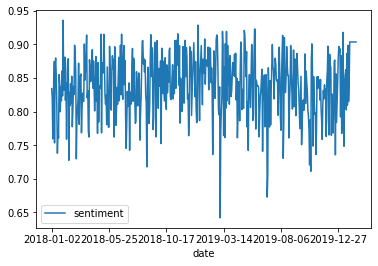

In [191]:
import matplotlib.pyplot as plt
s_apple.set_index('date').plot()

In [257]:
plot_full_data = full_data[['date','tic','sentiment']].set_index('date')

In [260]:
plot_full_data

tic  sentiment
date                       
2018-01-02  AAPL   0.834156
2018-01-02  AMGN   0.817893
2018-01-02   AXP   0.884115
2018-01-02    BA   0.791034
2018-01-02   CAT   0.830176
...          ...        ...
2020-02-12   UNH   0.823760
2020-02-12     V   0.798296
2020-02-12    VZ   0.869856
2020-02-12   WBA   0.788328
2020-02-12   WMT   0.800251

[15656 rows x 2 columns]

In [275]:
def plot_sentiments(df,fname):
    tickers = df.tic.unique()
    num_plots = len(tickers)
    fig = plt.figure(figsize=(16,16))
    cols = 5
    rows = int(num_plots / cols)
    gs = fig.add_gridspec(rows,cols)
    axes = gs.subplots(sharex='col',sharey='row')
    for i,tic in enumerate(tickers):
        c = i%cols
        r = i//cols
        plot_df = df[df['tic']==tic]
        axes[r,c].plot(plot_df.index,plot_df.sentiment)
        axes[r,c].set_title(tic)
    for ax in axes:
        try:
            ax.label_outer()
        except:
            pass
    plt.tight_layout()
    plt.savefig(os.path.join("/Users/rickgentry/github/BigData/RL-Sentiment-Stock-Trading/figs",fname))
    plt.show()


<ipython-input-275-db2b4098be15>:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


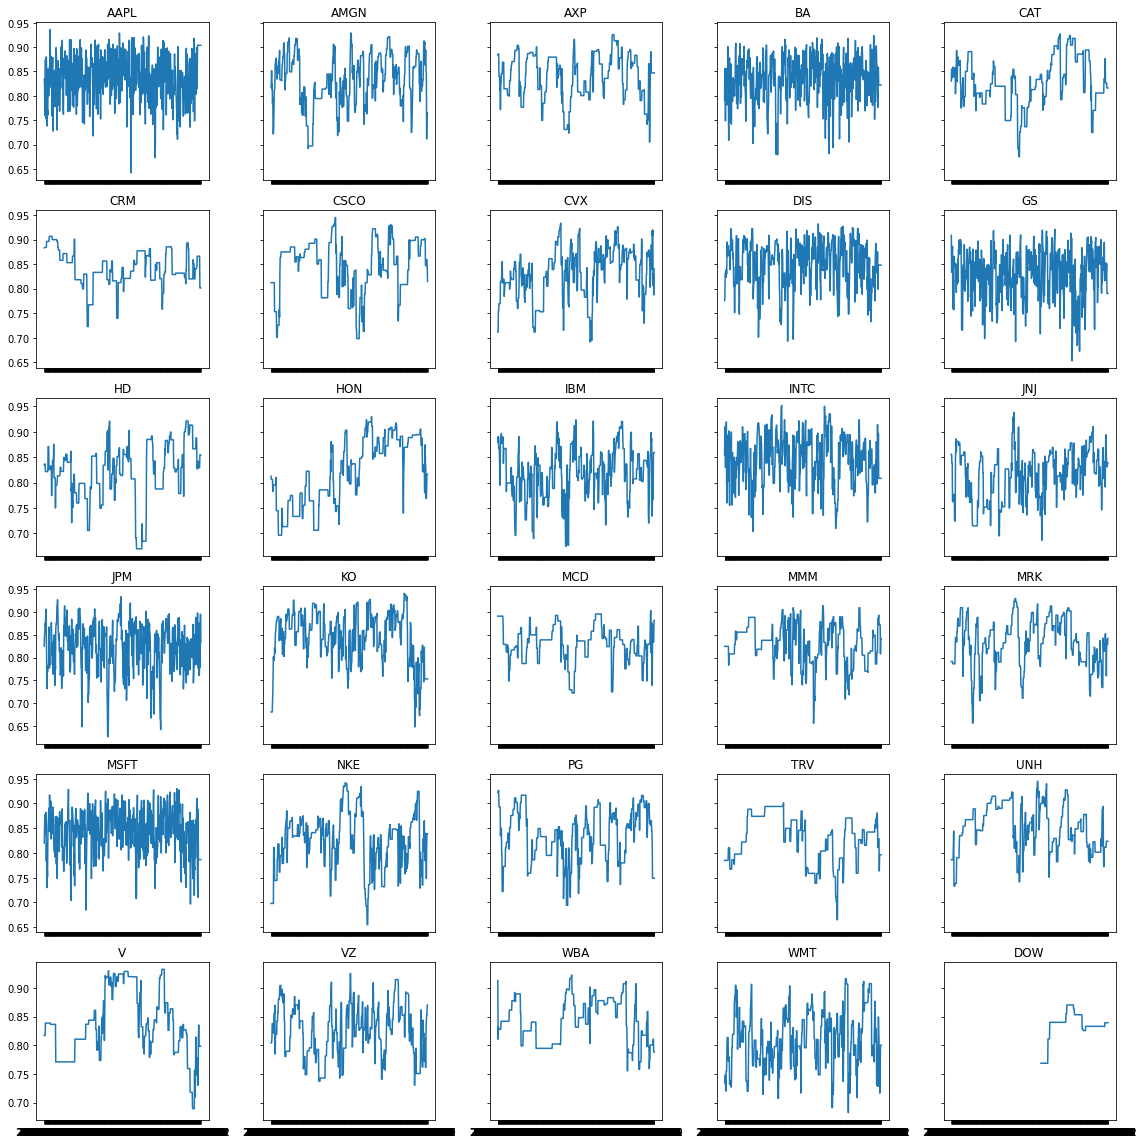

In [276]:
plot_sentiments(plot_full_data,"sentiment_plot")

In [192]:
full_data.to_csv(os.path.join(data_dir,"historical_feature_data_2018-2020.csv"))

In [194]:
train_data = full_data.sort_values(["date", "tic"], ignore_index=True)

In [195]:
train_data.index = train_data.date.factorize()[0]


In [212]:
len(train_data.loc[0])

29

In [204]:
from finrl.config import config
stock_dimension = len(train_data.tic.unique())
indicator_list = ['sentiment'] + config.TECHNICAL_INDICATORS_LIST
state_space = 1 + 2*stock_dimension + len(indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
env_kwargs = {
            "hmax": 100, 
            "initial_amount": 1000000, 
            "buy_cost_pct": 0.001, 
            "sell_cost_pct": 0.001, 
            "state_space": state_space, 
            "stock_dim": stock_dimension, 
            "tech_indicator_list": ['sentiment'] + indicator_list, 
            "action_space": stock_dimension, 
            "reward_scaling": 1e-4
            }

Stock Dimension: 30, State Space: 331


In [206]:
from model.train import create_training_environment, train_model
e_train = create_training_environment(train_data,env_kwargs)

In [209]:
save_model_path = '/Users/rickgentry/github/BigData/RL-Sentiment-Stock-Trading/trained_models/a2c_2018-2020'
trained_model = train_model(e_train,"a2c_2018-2020_log",save_model_path=save_model_path,train_timesteps=10000)

ValueError: could not broadcast input array from shape (350,) into shape (331,)

In [199]:
scores = dic.values()
tics = dic.keys()

In [23]:
scores, tics

(dict_values([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 dict_keys(['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT']))

In [26]:
list(dic.keys())

['MMM',
 'AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'CRM',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WBA',
 'WMT']